# Exercício 2 - Segunda Lista de Processamento de Imagens

Lorran de Araújo Durães Soares e Welber Paraizo Ferreira

**Estude a teoria da PCA para problemas com amostras pequenas**, onde o número de pontos de dados é menor
que a dimensão do espaço de dados (veja [3] ou a seção 12.1.4 de [1]). Escolha um banco de dados de imagens ([6],
por exemplo), converta as imagens para tons de cinza e aplique a teoria de ‘PCA para problemas com amostras pequenas’
para a redução de dimensionalidade.

1. **Seja** x a média amostral (centróide do conjunto de dados) e p1 o componente principal. Visualize o
   resultado da expressão:

   x = x + αp1

   onde α ∈ {−βλ1, 0, βλ1} com λ1 sendo o autovalor associado a p1
   e β um fator escalar (veja [5]).

2. **Estude o espectro da matriz** X^T X para realizar a redução de dimensionalidade. Visualize algumas
   imagens no espaço de dimensão reduzida.

3. **Construa um gerador de imagens** usando os d componentes principais escolhidos no item (2).



In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
np.random.seed(42)
random.seed(42)

# Preparação dos Dados

Carregando conjunto de imagens:

In [2]:
image_dir = './fei-database/'
images = []
image_paths = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img = img.resize((260, 360))  
    img_array = np.array(img)
    images.append(img_array)
    image_paths.append(img_path)  

images = np.array(images)
images.shape

(400, 360, 260, 3)

Plotando algumas imagens da base dados como exemplo:

In [3]:
def plot_images(imgs):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    for i in range(3):
        if imgs.shape == (400,360,260,3):
            axes[i].imshow(imgs[np.random.randint(0,399)], cmap='gray')
        else:
            image = imgs[np.random.randint(0,399)]
            axes[i].imshow(image.reshape(360, 260), cmap='gray')
        axes[i].set_title(f'Imagem exemplo {i+1}')
        axes[i].axis('off')  
    plt.show()

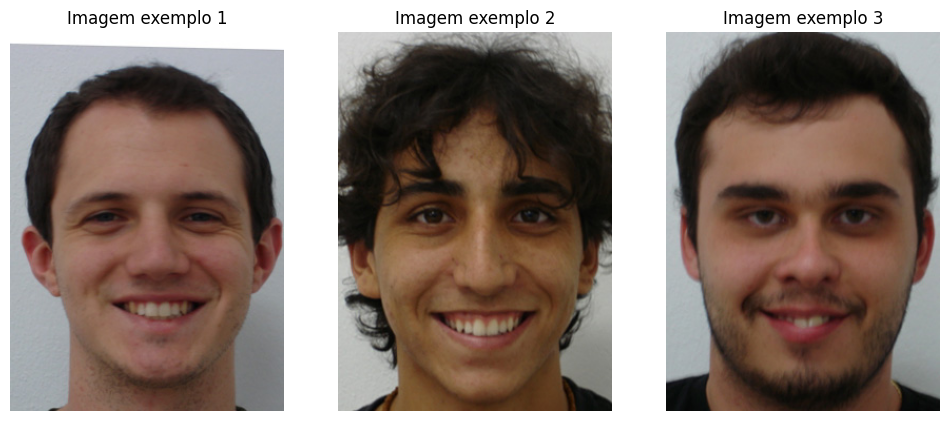

In [4]:
plot_images(images)

Pre-processamento:

In [5]:
def pre_processamento(images):
    # deixa em tom de cinza
    images_preproces = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

    # vetoriza
    images_preproces = images_preproces.reshape(images.shape[0], -1)

    # # normaliza
    # images_preproces = images_preproces / np.linalg.norm(images_preproces, axis=0)

    return images_preproces

In [6]:
images_preproces = pre_processamento(images)
images_preproces.shape

(400, 93600)

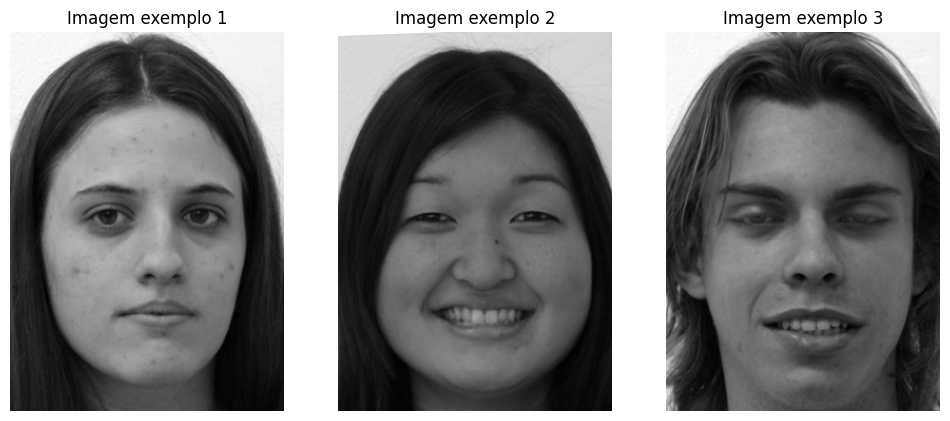

In [7]:
plot_images(images_preproces)

# Realizando PCA para poucas amostras

Produzindo classe com todas as funções necessárias para a realização da questão:

In [8]:
class PCAAnalysis:
    def __init__(self, data, n_components=None):
        """
        Inicializa a classe com o conjunto de dados e o número de componentes desejados.
        
        Parâmetros:
            data (numpy.ndarray): Conjunto de dados com as observações nas linhas e variáveis nas colunas.
            n_components (int, opcional): Número de componentes principais. Se None, mantém todos.
        """
        self.data = data
        self.n_components = n_components
        self.mean = None
        self.data_mean = None
        self.pca_base = None
        self.mean = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.transformed_data = None


    def truncate(self):
        """
        Reduz o número de componentes principais mantendo os dados truncados para n componentes.
        
        Parâmetros:
            n_components (int): Número de componentes a manter.
        
        Retorna:
            numpy.ndarray: Dados transformados com a quantidade de componentes truncada.
        """
        if self.eigenvectors is None:
             raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")
        
        if self.n_components != None:
            matriz = np.zeros((400, 400))
            np.fill_diagonal(matriz[:self.n_components, :self.n_components], 1)
            P_PCA = np.dot(self.eigenvectors, matriz)
            self.pca_base = P_PCA
        
        self.transformed_data = np.dot(self.data_mean, self.pca_base)

        return self.transformed_data
    

    def fit(self):
        """Realiza o ajuste PCA no conjunto de dados e transforma os dados para a nova base."""

        self.mean = np.mean(self.data, axis=0)
        self.data_mean = self.data - self.mean
        X = self.data_mean
        X_T = np.transpose(X)

        #V = (1/self.data.shape[0])*np.dot(X, X_T)
        V = (1/400)*np.dot(X, X_T)

        autovalores, autovetoresV = np.linalg.eigh(V)
        autovetores = np.dot(X_T, autovetoresV)
        autovetores = autovetores / np.linalg.norm(autovetores, axis=0)
        ordem_decrescente = np.argsort(autovalores)[::-1]
        autovalores = autovalores[ordem_decrescente]
        autovetores = autovetores[:, ordem_decrescente]
        
        self.eigenvalues = autovalores
        self.eigenvectors = autovetores
        self.pca_base = autovetores
        self.truncate()

        return self.transformed_data
  
    def plot_primeira_component(self, coeficiente, comp, larg, num_images=3):
        coeficientes = coeficiente*[-1, 0, 1]

        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        for i in range(num_images):
            imagem = self.mean + coeficientes[i] * np.sqrt(self.eigenvalues[0]) * self.eigenvectors[:, 0]
            axes[i].imshow(imagem.reshape(comp, larg), cmap='gray')
            axes[i].set_title(f'Coeficiente {i+1}')
            axes[i].axis('off')  

        plt.show()
    
    def plot_explained_variance(self):
        """Plota o espectro de variância explicada por cada componente principal."""

        if self.eigenvalues is None:
            raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")

        # Passo 1: Calcular a variância explicada
        variancia_explicada = self.eigenvalues / np.sum(self.eigenvalues)

        # Passo 2: Calcular a variância explicada acumulada
        variancia_explicada_acumulada = np.cumsum(variancia_explicada)

        self.n_components = np.argmax((variancia_explicada_acumulada) >= 0.95) + 1
        print(f"Número de componentes que representam 95% da variância dos dados: {self.n_components}")

        # Passo 3: Plotar o gráfico de energia dos autovalores
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(variancia_explicada)), variancia_explicada, alpha=0.6, label='Variância Explicada Individual')
        plt.step(range(len(variancia_explicada_acumulada)), variancia_explicada_acumulada, where='mid', color='red', label='Variância Explicada Acumulada')
        plt.xlabel('Número de Componentes Principais')
        plt.ylabel('Proporção da Variância Explicada')
        plt.title('Gráfico de Energia dos Autovalores (PCA)')
        plt.legend(loc='best')
        plt.show()


    def plot_pca_projection(self, dim1=0, dim2=1):
        """
        Plota os dados na base PCA em duas dimensões específicas.
        
        Parâmetros:
            dim1 (int): Índice da primeira dimensão a ser plotada.
            dim2 (int): Índice da segunda dimensão a ser plotada.
        """
        if self.transformed_data is None:
            raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")
        
        plt.figure(figsize=(8, 6))
        plt.scatter(self.transformed_data[:, dim1], self.transformed_data[:, dim2], alpha=0.7)
        plt.xlabel(f"Componente Principal {dim1 + 1}")
        plt.ylabel(f"Componente Principal {dim2 + 1}")
        plt.title("Projeção dos Dados na Base PCA")
        plt.grid(True)
        plt.show()

    
    def reconstrucion_images(self):
        imagem_reduzida = self.mean + np.dot(self.transformed_data, np.transpose(self.pca_base))

        num_imagens = 4  

        fig, axes = plt.subplots(2, 4, figsize=(10, 8))  
        fig.subplots_adjust(hspace=0.3)  

        for i in range(num_imagens):
            # Plotar imagem reduzida na primeira linha
            axes[0, i].imshow(imagem_reduzida[20*i].reshape(360, 260), cmap='gray')
            axes[0, i].set_title(f'Reconstruída {i+1}')
            axes[0, i].axis('off')  

            # Plotar imagem original na segunda linha
            axes[1, i].imshow(self.data[20*i].reshape(360, 260), cmap='gray')
            axes[1, i].set_title(f'Original {i+1}')
            axes[1, i].axis('off') # Remove os eixos para uma visualização limpa

        plt.show()

    def image_generator(self, n_principal_components, n_imagens):
    
        fig, axs = plt.subplots(1, n_imagens, figsize=(5 * n_imagens, 5))

        if n_imagens == 1:
            axs = [axs]

        for j in range(n_imagens):
        
            img = np.copy(self.mean)
        
            
            for i in range(n_principal_components):
                coeficiente = np.random.uniform(-1, 1)
                img += coeficiente * np.sqrt(self.eigenvalues[i]) * self.eigenvectors[:, i]

            im = axs[j].imshow(img.reshape(360, 260), cmap='gray')
            fig.colorbar(im, ax=axs[j], orientation='vertical')  
            axs[j].grid(False)

    plt.show()


Treinando o PCA:

In [9]:
pca_small_size = PCAAnalysis(images_preproces)
pca_small_size.fit();

Plotando imagens com apenas a componente principal:

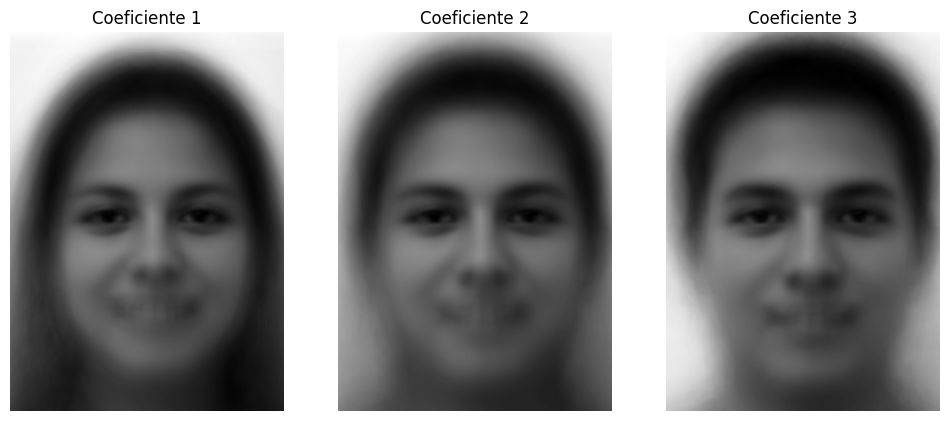

In [10]:
pca_small_size.plot_primeira_component(coeficiente=1000, comp=360, larg=260)

Análise do espectro e truncamento automático para 95% de energia dos autovalores:

Número de componentes que representam 95% da variância dos dados: 110


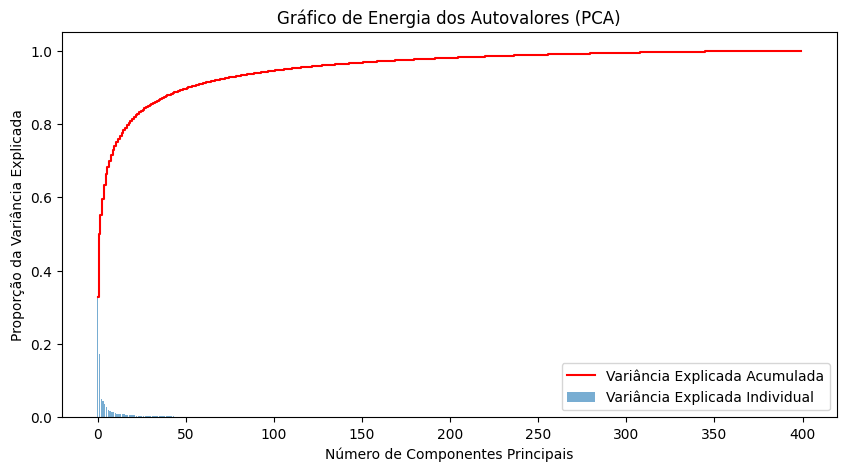

In [11]:
pca_small_size.plot_explained_variance()

Realizando truncamento em 100, criando matriz quadrada de 400x400, mas com até a centésima posição da diagonal com o número 1, e o resto com 0:

In [12]:
pca_small_size.truncate();

Plota o conjunto das imagens na dimensão obtida pelo P_PCA:

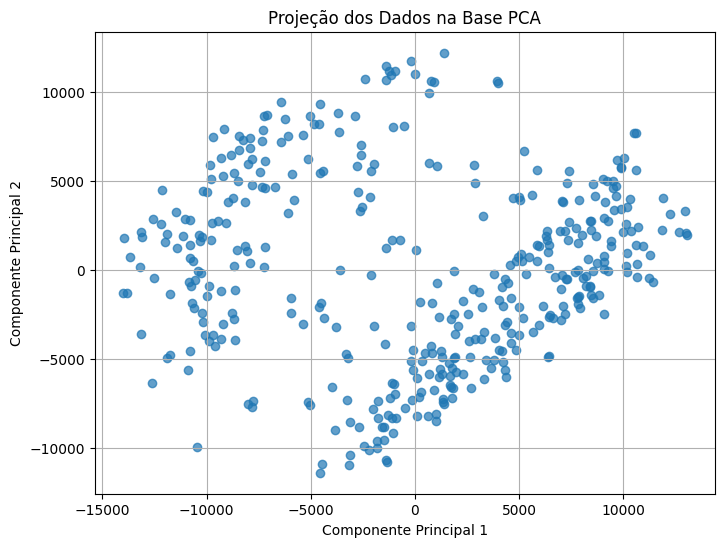

In [13]:
pca_small_size.plot_pca_projection()

Visualizando imagens após redução de dimensionalidade:

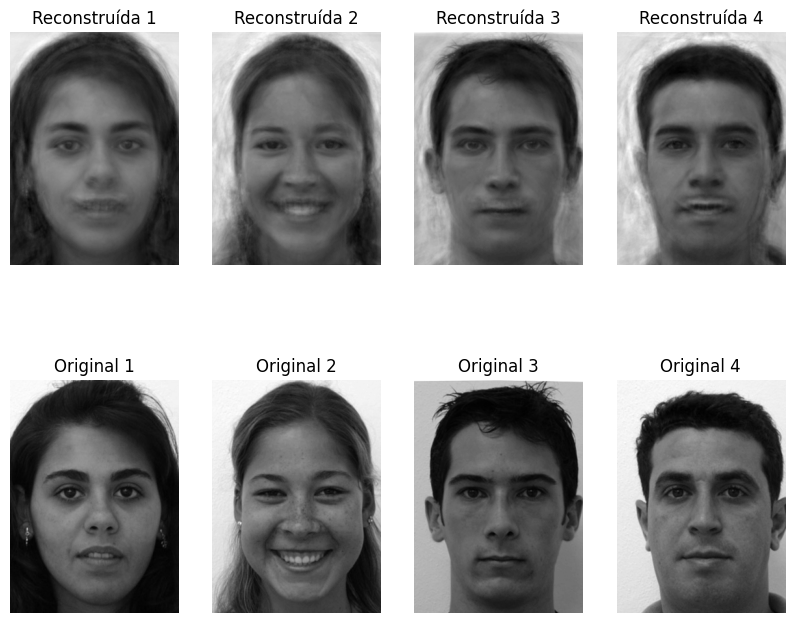

In [14]:
pca_small_size.reconstrucion_images()

c) fazendo gerador de imagens:

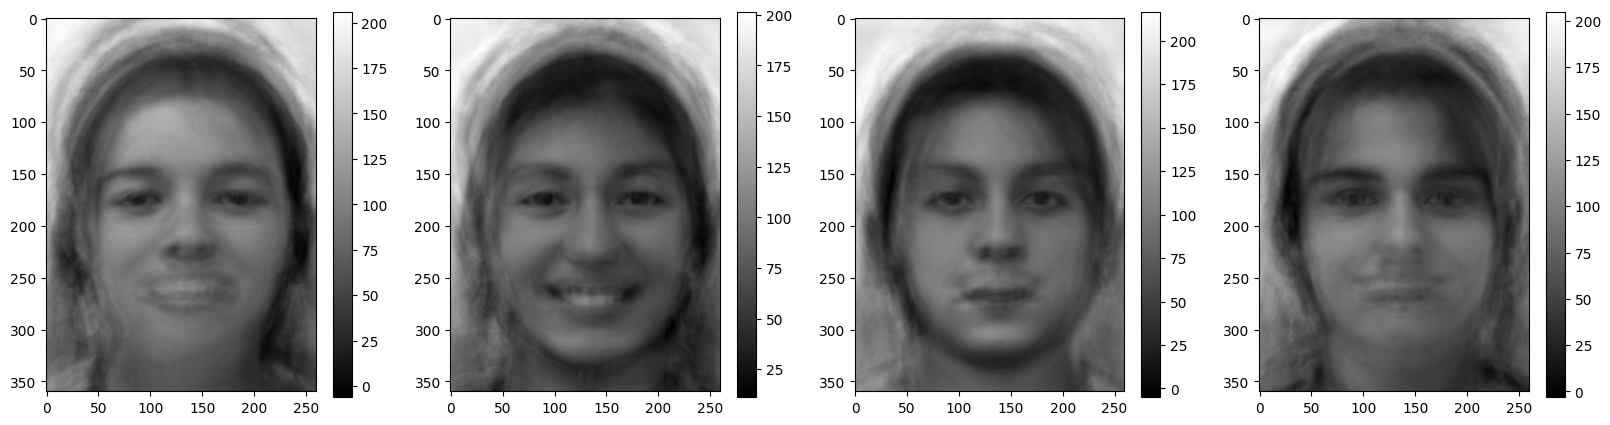

In [18]:
n_principal_components = 110
n_imagens = 4

pca_small_size.image_generator(n_principal_components, n_imagens)

Falta fazer plot em duas dimensoes separando sorrindo e serio (ou homem e mulher se der)